In [11]:
!unzip -FF '/content/archive.zip'

Archive:  /content/archive.zip
  inflating: OCTID/CSR/CSR1.jpeg     
  inflating: OCTID/CSR/CSR10.jpeg    
  inflating: OCTID/CSR/CSR100.jpeg   
  inflating: OCTID/CSR/CSR101.jpeg   
  inflating: OCTID/CSR/CSR102.jpeg   
  inflating: OCTID/CSR/CSR11.jpeg    
  inflating: OCTID/CSR/CSR12.jpeg    
  inflating: OCTID/CSR/CSR13.jpeg    
  inflating: OCTID/CSR/CSR14.jpeg    
  inflating: OCTID/CSR/CSR15.jpeg    
  inflating: OCTID/CSR/CSR16.jpeg    
  inflating: OCTID/CSR/CSR17.jpeg    
  inflating: OCTID/CSR/CSR18.jpeg    
  inflating: OCTID/CSR/CSR19.jpeg    
  inflating: OCTID/CSR/CSR2.jpeg     
  inflating: OCTID/CSR/CSR20.jpeg    
  inflating: OCTID/CSR/CSR21.jpeg    
  inflating: OCTID/CSR/CSR22.jpeg    
  inflating: OCTID/CSR/CSR23.jpeg    
  inflating: OCTID/CSR/CSR24.jpeg    
  inflating: OCTID/CSR/CSR25.jpeg    
  inflating: OCTID/CSR/CSR26.jpeg    
  inflating: OCTID/CSR/CSR27.jpeg    
  inflating: OCTID/CSR/CSR28.jpeg    
  inflating: OCTID/CSR/CSR29.jpeg    
  inflating: OCTID/

In [12]:
!unzip -q archive.zip -d dataset


In [13]:
import os

root = "dataset"
for cls in os.listdir(root):
    p = os.path.join(root, cls)
    if os.path.isdir(p):
        print(cls, "->", len(os.listdir(p)), "images")


OCTID -> 4 images


In [14]:
data_path = "dataset/OCTID"


In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(data_path, transform=train_tf)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

print("Classes:", train_data.classes)
print("Total images:", len(train_data))


Classes: ['CSR', 'DR', 'MH', 'NORMAL']
Total images: 517


In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "dataset/OCTID"   # your path
num_classes = 4


In [17]:
# transforms: resize to 224 (ViT default), use ImageNet normalization
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


In [18]:
full_ds = datasets.ImageFolder(data_path, transform=train_tf)  # start with train_tf, we'll swap for val subset
labels = [s[1] for s in full_ds.samples]

train_idx, val_idx = train_test_split(
    list(range(len(labels))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_ds = Subset(full_ds, train_idx)
# ensure val uses val_tf normalization/transform
val_ds = Subset(datasets.ImageFolder(data_path, transform=val_tf), val_idx)

print("train:", len(train_ds), "val:", len(val_ds))
print("classes:", full_ds.classes)


train: 413 val: 104
classes: ['CSR', 'DR', 'MH', 'NORMAL']


In [21]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [4]:
import timm # keep switching models here

model = timm.create_model(
    'maxvit_rmlp_base_rw_224',
    pretrained=False,   # ← important
    num_classes=num_classes
).to(device)


In [44]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=15)

In [46]:
# === CELL A (restored + small fixes): Diagnostic-Stabilized Training ===
import time, numpy as np, torch, math, gc
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
import torch.nn as nn
from pathlib import Path
import random

# ----------------- Hyperparameters -----------------
EPOCHS = 15                 #used 25 epochs earlier — change if needed
WARMUP_EPOCHS = 3
BACKBONE_LR = 1e-4
HEAD_LR = 1e-3
WEIGHT_DECAY = 1e-2
GRAD_CLIP_NORM = 1.0
LABEL_SMOOTH = 0.1
SAVE_BEST_PATH = "best_model.pth"
SEED = 42
# ---------------------------------------------------

# deterministic-ish
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

use_amp = (device == "cuda")
# Use the newer torch.amp API as suggested by warnings
scaler = torch.amp.GradScaler('cuda', enabled=use_amp) # Updated line

# Split head vs backbone params
head_params = []
backbone_params = []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if "head" in n.lower() or "classifier" in n.lower():
        head_params.append(p)
    else:
        backbone_params.append(p)

# fallback heuristics
if len(head_params) == 0:
    try:
        head_params = list(model.head.parameters())
        backbone_params = [p for p in model.parameters() if p not in head_params]
    except Exception:
        head_params = []
        backbone_params = list(model.parameters())

# build param groups; ensure order: head (if exists) then backbone
param_groups = []
if head_params:
    param_groups.append({"params": head_params, "lr": HEAD_LR})
param_groups.append({"params": backbone_params, "lr": BACKBONE_LR})

opt = torch.optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)

# Scheduler: warmup (lambda) + cosine
base_cosine = CosineAnnealingLR(opt, T_max=max(1, EPOCHS - WARMUP_EPOCHS))
def warmup_lambda(e):
    if WARMUP_EPOCHS <= 0:
        return 1.0
    return min(1.0, (e + 1) / float(WARMUP_EPOCHS))

# We'll step warmup_scheduler for the first WARMUP_EPOCHS epochs, then use base_cosine.
warmup_scheduler = LambdaLR(opt, lr_lambda=warmup_lambda)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

train_losses = []
val_accuracies = []
best_val = -1.0
best_epoch = 0

for epoch in range(EPOCHS):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    total_samples = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        opt.zero_grad()
        # Use the newer torch.amp API for autocast
        with torch.amp.autocast('cuda', enabled=use_amp): # Updated line
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()

        if use_amp:
            scaler.unscale_(opt)

        # raw grad norm (optional diagnostic - not used further here)
        total_norm_raw = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_norm_raw += (p.grad.data.norm(2).item() ** 2)
        total_norm_raw = total_norm_raw ** 0.5

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)

        scaler.step(opt)
        scaler.update()

        running_loss += float(loss.item()) * imgs.size(0)
        total_samples += imgs.size(0)

    # scheduler stepping: use warmup scheduler for first WARMUP_EPOCHS, then base cosine (offset the epoch for cosine)
    if epoch < WARMUP_EPOCHS:
        warmup_scheduler.step()
    else:
        # step the cosine with epoch index after warmup
        base_cosine.step()

    epoch_loss = running_loss / (total_samples if total_samples > 0 else 1)
    train_losses.append(epoch_loss)

    # validation accuracy
    model.eval()
    ys, yps = [], []
    with torch.no_grad():
        for imgs_v, labels_v in val_loader:
            imgs_v = imgs_v.to(device, non_blocking=True)
            labels_v = labels_v.to(device, non_blocking=True).long()
            with torch.amp.autocast('cuda', enabled=use_amp): # Updated line
                logits_v = model(imgs_v)
            preds_v = logits_v.argmax(dim=1)
            ys.extend(labels_v.cpu().numpy().tolist())
            yps.extend(preds_v.cpu().numpy().tolist())

    val_acc = float(np.mean(np.array(ys) == np.array(yps)))
    val_accuracies.append(val_acc)

    if val_acc > best_val:
        best_val = val_acc
        best_epoch = epoch + 1
        # save model + optimizer + extra metadata
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'val_acc': val_acc,
            'train_loss': epoch_loss
        }, SAVE_BEST_PATH)

    # safe lr printing: param_groups ordering may vary
    lrs = [g.get('lr', None) for g in opt.param_groups]
    # try to infer head/backbone order
    if len(lrs) == 1:
        lr_head = lrs[0]
        lr_backbone = lrs[0]
    else:
        # if head present, we built param_groups with head first then backbone
        if head_params:
            lr_head, lr_backbone = lrs[0], lrs[1]
        else:
            lr_head, lr_backbone = lrs[-1], lrs[0]

    print(
        f"Epoch {epoch+1}/{EPOCHS}  "
        f"loss={epoch_loss:.4f}  "
        f"val_acc={val_acc:.4f}  "
        f"lr_backbone={lr_backbone:.2e}  lr_head={lr_head:.2e}  "
        f"time={time.time()-t0:.1f}s"
    )

    # free memory periodically
    gc.collect()
    if device.startswith("cuda"):
        torch.cuda.empty_cache()

# persist training traces
np.save("train_losses.npy", np.array(train_losses))
np.save("val_accuracies.npy", np.array(val_accuracies))

print(f"Training complete. Best val_acc={best_val:.4f} at epoch {best_epoch}.")
print("Saved:", SAVE_BEST_PATH)


/tmp/ipython-input-344723407.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-344723407.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-344723407.py:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 1/15  loss=0.7290  val_acc=0.9327  lr_backbone=6.67e-05  lr_head=6.67e-04  time=11.3s
Epoch 2/15  loss=0.4457  val_acc=0.9327  lr_backbone=1.00e-04  lr_head=1.00e-03  time=5.5s
Epoch 3/15  loss=0.3941  val_acc=0.9712  lr_backbone=1.00e-04  lr_head=1.00e-03  time=14.5s
Epoch 4/15  loss=0.3799  val_acc=0.9808  lr_backbone=9.83e-05  lr_head=9.83e-04  time=11.8s
Epoch 5/15  loss=0.3599  val_acc=0.9423  lr_backbone=9.33e-05  lr_head=9.33e-04  time=5.8s
Epoch 6/15  loss=0.3712  val_acc=0.9808  lr_backbone=8.54e-05  lr_head=8.54e-04  time=7.1s
Epoch 7/15  loss=0.3697  val_acc=0.9615  lr_backbone=7.50e-05  lr_head=7.50e-04  time=5.6s
Epoch 8/15  loss=0.3502  val_acc=0.9808  lr_backbone=6.29e-05  lr_head=6.29e-04  time=6.4s
Epoch 9/15  loss=0.3493  val_acc=0.9808  lr_backbone=5.00e-05  lr_head=5.00e-04  time=5.5s
Epoch 10/15  loss=0.3490  val_acc=0.9808  lr_backbone=3.71e-05  lr_head=3.71e-04  time=6.0s
Epoch 11/15  loss=0.3490  val_acc=0.9808  lr_backbone=2.50e-05  lr_head=2.50e-04  time

Could not load best_model.pth into model (skipping). Error: Error(s) in loading state_dict for VisionTransformer:
	Missing key(s) in state_dict: "cls_token", "pos_embed", "patch_embed.proj.weight", "patch_embed.proj.bias", "blocks.0.norm1.weight", "blocks.0.norm1.bias", "blocks.0.attn.qkv.weight", "blocks.0.attn.qkv.bias", "blocks.0.attn.proj.weight", "blocks.0.attn.proj.bias", "blocks.0.norm2.weight", "blocks.0.norm2.bias", "blocks.0.mlp.fc1.weight", "blocks.0.mlp.fc1.bias", "blocks.0.mlp.fc2.weight", "blocks.0.mlp.fc2.bias", "blocks.1.norm1.weight", "blocks.1.norm1.bias", "blocks.1.attn.qkv.weight", "blocks.1.attn.qkv.bias", "blocks.1.attn.proj.weight", "blocks.1.attn.proj.bias", "blocks.1.norm2.weight", "blocks.1.norm2.bias", "blocks.1.mlp.fc1.weight", "blocks.1.mlp.fc1.bias", "blocks.1.mlp.fc2.weight", "blocks.1.mlp.fc2.bias", "blocks.2.norm1.weight", "blocks.2.norm1.bias", "blocks.2.attn.qkv.weight", "blocks.2.attn.qkv.bias", "blocks.2.attn.proj.weight", "blocks.2.attn.proj.bias",

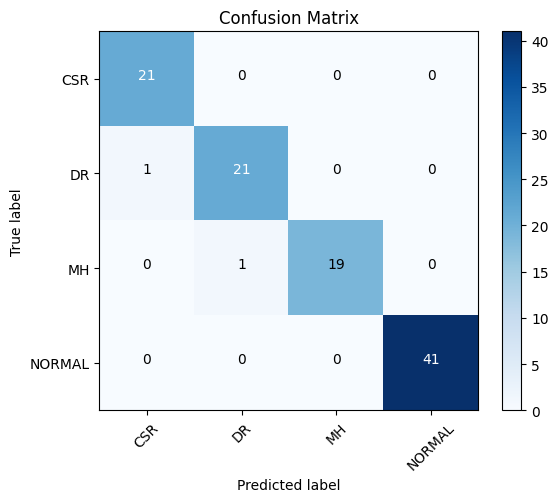

/tmp/ipython-input-1268197482.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


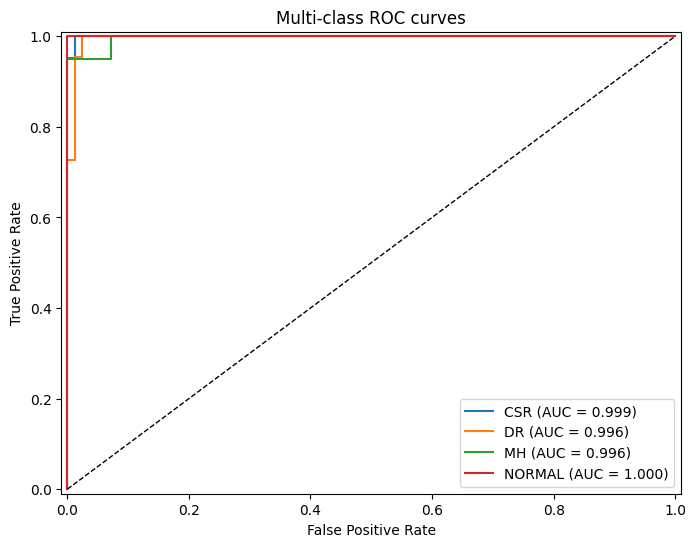

Per-class AUCs: {'CSR': np.float64(0.9994), 'DR': np.float64(0.9961), 'MH': np.float64(0.9964), 'NORMAL': np.float64(1.0)}
Macro AUC: 0.9980


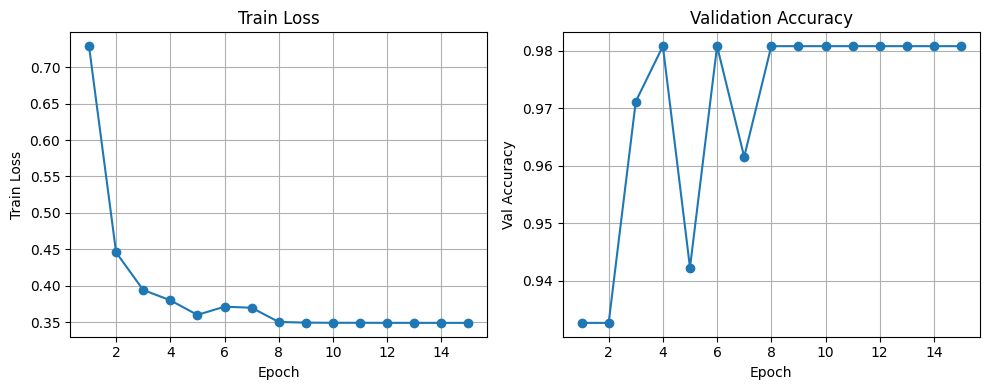

Saved per-class summary to val_summary.csv

Evaluation complete.


In [47]:
# === CELL B: Evaluation & Plots===
# Precondition: device, val_loader, model, num_classes, class_names exist.
# This cell will load best_model.pth (if present), run inference on val set,
# print metrics (accuracy, per-class precision/recall/f1/support), produce
# confusion matrix, ROC/AUC (per-class + macro), and plot loss/accuracy curves
# saved as train_losses.npy / val_accuracies.npy.

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score,
)
from sklearn.preprocessing import label_binarize
class_names = train_loader.dataset.dataset.classes

# --- load best model if available (optional) ---
if os.path.exists("best_model.pth"):
    sd = torch.load("best_model.pth", map_location=device)
    try:
        model.load_state_dict(sd)
        print("Loaded best_model.pth")
    except Exception as e:
        print("Could not load best_model.pth into model (skipping). Error:", e)

model.to(device)
model.eval()

# --- collect predictions & probabilities on validation set ---
y_true = []
y_pred = []
probs_list = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.tolist())
        probs_list.append(probs)

if len(probs_list) == 0:
    raise RuntimeError("Validation loader produced no batches. Check val_loader.")

probs_all = np.vstack(probs_list)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- basic metrics ---
acc = (y_pred == y_true).mean()
print(f"\nValidation accuracy: {acc:.4f}\n")

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=list(range(num_classes)), zero_division=0
)

print("Per-class metrics (index, name):")
for i, name in enumerate(class_names):
    print(f" {i}  {name:12s}  precision={precision[i]:.4f}  recall={recall[i]:.4f}  f1={f1[i]:.4f}  support={int(support[i])}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0, digits=4))

# --- confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)
thresh = cm.max() / 2. if cm.max() != 0 else 1.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# --- ROC / AUC (multi-class) ---
# Need binarized true labels
try:
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    # compute per-class AUCs and plot ROC curves where possible
    plt.figure(figsize=(8,6))
    colors = plt.cm.get_cmap('tab10')
    per_class_auc = {}
    for c in range(num_classes):
        # skip plotting if only one label present for that class in val set
        if np.unique(y_true_bin[:, c]).size == 1:
            per_class_auc[class_names[c]] = np.nan
            print(f"Class '{class_names[c]}' has only one label present in val set - skipping ROC for this class.")
            continue
        fpr, tpr, _ = roc_curve(y_true_bin[:, c], probs_all[:, c])
        roc_auc = auc(fpr, tpr)
        per_class_auc[class_names[c]] = roc_auc
        plt.plot(fpr, tpr, label=f"{class_names[c]} (AUC = {roc_auc:.3f})", color=colors(c))
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC curves')
    plt.legend(loc='lower right')
    plt.show()

    try:
        macro_auc = roc_auc_score(y_true_bin, probs_all, average='macro')
    except Exception:
        macro_auc = np.nan
    print("Per-class AUCs:", {k: (np.nan if np.isnan(v) else round(v,4)) for k,v in per_class_auc.items()})
    print(f"Macro AUC: {macro_auc:.4f}" if not np.isnan(macro_auc) else "Macro AUC: nan")
except Exception as e:
    print("Could not compute ROC/AUC (maybe degenerate class in val set). Error:", e)

# --- Plot loss & accuracy curves if saved arrays exist ---
try:
    train_losses = np.load("train_losses.npy")
    val_accuracies = np.load("val_accuracies.npy")
    epochs_range = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Train Loss")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_accuracies, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy")
    plt.title("Validation Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception:
    print("train_losses.npy or val_accuracies.npy not found or could not be loaded - skipping curves.")

# --- Optional: save a small CSV summary ---
try:
    import csv
    summary_csv = "val_summary.csv"
    with open(summary_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["class", "precision", "recall", "f1", "support", "auc"])
        for i, name in enumerate(class_names):
            auc_val = per_class_auc.get(name, np.nan) if 'per_class_auc' in locals() else np.nan
            writer.writerow([name, precision[i], recall[i], f1[i], int(support[i]), ("" if np.isnan(auc_val) else float(auc_val))])
    print(f"Saved per-class summary to {summary_csv}")
except Exception:
    pass

print("\nEvaluation complete.")


In [4]:
import timm
[x for x in timm.list_models() if 'maxvit' in x.lower()]


['maxvit_base_tf_224',
 'maxvit_base_tf_384',
 'maxvit_base_tf_512',
 'maxvit_large_tf_224',
 'maxvit_large_tf_384',
 'maxvit_large_tf_512',
 'maxvit_nano_rw_256',
 'maxvit_pico_rw_256',
 'maxvit_rmlp_base_rw_224',
 'maxvit_rmlp_base_rw_384',
 'maxvit_rmlp_nano_rw_256',
 'maxvit_rmlp_pico_rw_256',
 'maxvit_rmlp_small_rw_224',
 'maxvit_rmlp_small_rw_256',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_small_tf_224',
 'maxvit_small_tf_384',
 'maxvit_small_tf_512',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxvit_tiny_tf_224',
 'maxvit_tiny_tf_384',
 'maxvit_tiny_tf_512',
 'maxvit_xlarge_tf_224',
 'maxvit_xlarge_tf_384',
 'maxvit_xlarge_tf_512']